# Student Grade Regression - Math - LightGBM

## Import base libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data preprocessing

In [2]:
df = pd.read_csv('student-mat.csv')  # Math class
# df = pd.read_csv('student-por.csv')  # Portuguese class
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

print(X.shape, y.shape)

(395, 32) (395,)


In [3]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [4]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [5]:
# Identify all categorical columns
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no
3,GP,F,U,GT3,T,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


In [6]:
# Identify all numerical columns
obj_df = df.select_dtypes(include=['int64']).copy()
obj_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10


In [7]:
# Check for missing values
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [8]:
# Categorical Columns (indices) - 0:1, 3:5, 8:11, 15:22
from sklearn.preprocessing import LabelEncoder

# Label Encode - 0:1, 3:5, 15:22
le = LabelEncoder()
# le_columns = X[:, [0, 1, 3, 4, 5, 15, 16, 17, 18, 19, 20, 21, 22]]

# for i in X[:]:
#   if i in le_columns:
#     X[:, i] = le.fit_transform(X[:, i])

# Encode nominal attributes
X[:, 0] = le.fit_transform(X[:, 0])
X[:, 1] = le.fit_transform(X[:, 1])
X[:, 3] = le.fit_transform(X[:, 3])
X[:, 4] = le.fit_transform(X[:, 4])
X[:, 5] = le.fit_transform(X[:, 5])
X[:, 8] = le.fit_transform(X[:, 8])
X[:, 9] = le.fit_transform(X[:, 9])
X[:, 10] = le.fit_transform(X[:, 10])
X[:, 11] = le.fit_transform(X[:, 11])

# Encode binary attributes
X[:, 15] = le.fit_transform(X[:, 15])
X[:, 16] = le.fit_transform(X[:, 16])
X[:, 17] = le.fit_transform(X[:, 17])
X[:, 18] = le.fit_transform(X[:, 18])
X[:, 19] = le.fit_transform(X[:, 19])
X[:, 20] = le.fit_transform(X[:, 20])
X[:, 21] = le.fit_transform(X[:, 21])
X[:, 22] = le.fit_transform(X[:, 22])

print(X)

[[0 0 18 ... 6 5 6]
 [0 0 17 ... 4 5 5]
 [0 0 15 ... 10 7 8]
 ...
 [1 1 21 ... 3 10 8]
 [1 1 18 ... 0 11 12]
 [1 1 19 ... 5 8 9]]


In [9]:
# Split dataframe (df) into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [10]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [11]:
# Apply PCA (dimensionality reduction)
# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

## Define LightGBM model

In [12]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

reg = LGBMRegressor(max_depth=2, n_estimators=115, learning_rate=0.16, 
                    colsample_bytree=1, num_leaves=4, reg_alpha=2.2,
                    subsample=1, subsample_freq=1, random_state=0)
reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.16, max_depth=2,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=115, n_jobs=-1, num_leaves=4, objective=None,
              random_state=0, reg_alpha=2.2, reg_lambda=0.0, silent=True,
              subsample=1, subsample_for_bin=200000, subsample_freq=1)

## Evaluate model

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict test set results
y_pred = reg.predict(X_test)
np.set_printoptions(precision = 2)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1 ))
print('')

# Summarize results
print('MAE: %.3f' % (mean_absolute_error(y_test, y_pred)))
print('MSE: %.3f' % (mean_squared_error(y_test, y_pred)))
print('RMSE: %.3f' % (mean_squared_error(y_test, y_pred, squared=False)))
print('R^2 Score: %.3f' % (r2_score(y_test, y_pred)))


[[13.39 14.  ]
 [10.7  10.  ]
 [ 9.8   9.  ]
 [15.25 15.  ]
 [15.87 16.  ]
 [12.66 12.  ]
 [13.08 14.  ]
 [10.33 11.  ]
 [ 9.86  9.  ]
 [13.97 15.  ]
 [ 8.69 10.  ]
 [11.48 11.  ]
 [11.63 10.  ]
 [10.13  8.  ]
 [14.04 15.  ]
 [13.54 14.  ]
 [12.71 12.  ]
 [ 9.19  0.  ]
 [ 8.86 10.  ]
 [14.32 16.  ]
 [ 8.61  0.  ]
 [ 4.52  0.  ]
 [ 7.22  8.  ]
 [14.01 16.  ]
 [12.45 12.  ]
 [15.43 15.  ]
 [ 9.03 10.  ]
 [18.34 19.  ]
 [ 5.11  0.  ]
 [13.61 14.  ]
 [ 5.48  0.  ]
 [ 8.99 10.  ]
 [ 8.26  8.  ]
 [ 5.23  4.  ]
 [12.98 13.  ]
 [ 9.9  10.  ]
 [12.91 13.  ]
 [16.8  18.  ]
 [ 9.63  8.  ]
 [11.95 11.  ]
 [ 6.26  6.  ]
 [18.08 18.  ]
 [ 7.18  8.  ]
 [ 9.54  8.  ]
 [10.89 11.  ]
 [ 5.08  0.  ]
 [12.19 13.  ]
 [ 5.23  0.  ]
 [13.28 13.  ]
 [ 8.89  7.  ]
 [ 9.23 10.  ]
 [18.03 18.  ]
 [11.67 10.  ]
 [ 8.15  9.  ]
 [11.87 11.  ]
 [ 9.89  6.  ]
 [ 9.02  9.  ]
 [12.32 13.  ]
 [13.85 15.  ]
 [13.82 14.  ]
 [12.62 14.  ]
 [14.47 15.  ]
 [12.85 14.  ]
 [14.65 15.  ]
 [ 9.21  0.  ]
 [14.95 15.  ]
 [16.76 19

<table border = "1">
  <thead>
    <th colspan = "5">Prediction Scores</th>
  </thead>
  <tbody>
    <tr>
      <td><b>MAE:<b></td>
      <td>1.681</td>
    </tr>
    <tr>
      <td><b>MSE:<b></td>
      <td>7.971</td>
    </tr>
    <tr>
      <td><b>RMSE:<b></td>
      <td>2.823</td>
    </tr>
    <tr>
      <td><b>R^2:<b></td>
      <td>0.711</td>
    </tr>
  </tbody>
</table>

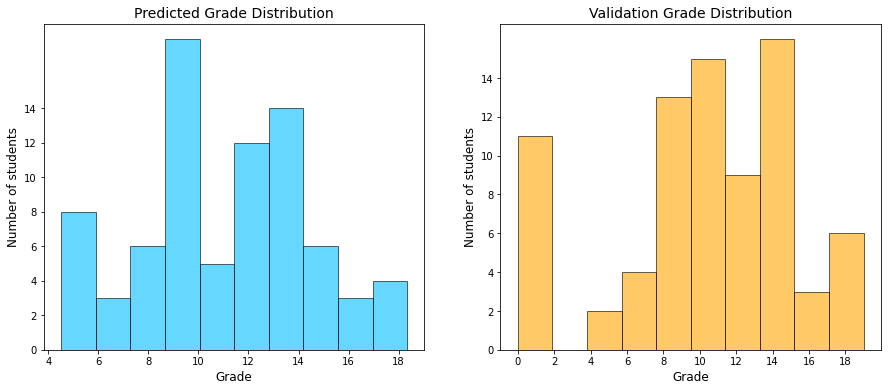

In [14]:
# Plot histogram for y_pred
fig1 = plt.figure(figsize=(15, 6))
ax1 = fig1.add_subplot(1, 2, 1)
plt.xticks(np.arange(0, 20, 2))
plt.yticks(np.arange(0, 16, 2))
plt.hist(x=y_pred, facecolor='deepskyblue', alpha=0.6, edgecolor='black')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Number of students', fontsize=12)
plt.title('Predicted Grade Distribution', fontsize=14)

# Plot histogram for y_test
ax1 = fig1.add_subplot(1, 2, 2)
plt.xticks(np.arange(0, 20, 2))
plt.yticks(np.arange(0, 16, 2))
plt.hist(x=y_test, facecolor='orange', alpha=0.6, edgecolor='black')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Number of students', fontsize=12)
plt.title('Validation Grade Distribution', fontsize=14)

# Show subplot
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 1 --

R^2 Scoring:
Mean: 0.835119
Std: +/- 0.026799
Min: 0.781152
Max: 0.861231

RMSE Scoring:
Mean: 1.774093
Std: +/- 0.117110
Min: 1.667356
Max: 2.010909



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)



-- Fold: 2 --

R^2 Scoring:
Mean: 0.865957
Std: +/- 0.012300
Min: 0.841285
Max: 0.885135

RMSE Scoring:
Mean: 1.604984
Std: +/- 0.076435
Min: 1.482098
Max: 1.757331



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 3 --

R^2 Scoring:
Mean: 0.868442
Std: +/- 0.035351
Min: 0.789076
Max: 0.905771

RMSE Scoring:
Mean: 1.576760
Std: +/- 0.203525
Min: 1.315665
Max: 2.019727



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)



-- Fold: 4 --

R^2 Scoring:
Mean: 0.868503
Std: +/- 0.044104
Min: 0.740084
Max: 0.913509

RMSE Scoring:
Mean: 1.570151
Std: +/- 0.244211
Min: 1.296026
Max: 2.217369



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 5 --

R^2 Scoring:
Mean: 0.871511
Std: +/- 0.038786
Min: 0.764543
Max: 0.918626

RMSE Scoring:
Mean: 1.551514
Std: +/- 0.201295
Min: 1.268156
Max: 2.101731



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 6 --

R^2 Scoring:
Mean: 0.870601
Std: +/- 0.062538
Min: 0.646511
Max: 0.945838

RMSE Scoring:
Mean: 1.537996
Std: +/- 0.328654
Min: 1.038470
Max: 2.581423



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 7 --

R^2 Scoring:
Mean: 0.877696
Std: +/- 0.037035
Min: 0.803328
Max: 0.941041

RMSE Scoring:
Mean: 1.508587
Std: +/- 0.221088
Min: 1.007504
Max: 1.931766



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 


-- Fold: 8 --

R^2 Scoring:
Mean: 0.877079
Std: +/- 0.052614
Min: 0.745587
Max: 0.950209

RMSE Scoring:
Mean: 1.503859
Std: +/- 0.314909
Min: 0.983958
Max: 2.181326



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class


-- Fold: 9 --

R^2 Scoring:
Mean: 0.878564
Std: +/- 0.054864
Min: 0.707315
Max: 0.953128

RMSE Scoring:
Mean: 1.487211
Std: +/- 0.339309
Min: 0.937483
Max: 2.429817



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class


-- Fold: 10 --

R^2 Scoring:
Mean: 0.882857
Std: +/- 0.056629
Min: 0.755811
Max: 0.967814

RMSE Scoring:
Mean: 1.451302
Std: +/- 0.386905
Min: 0.799545
Max: 2.251709



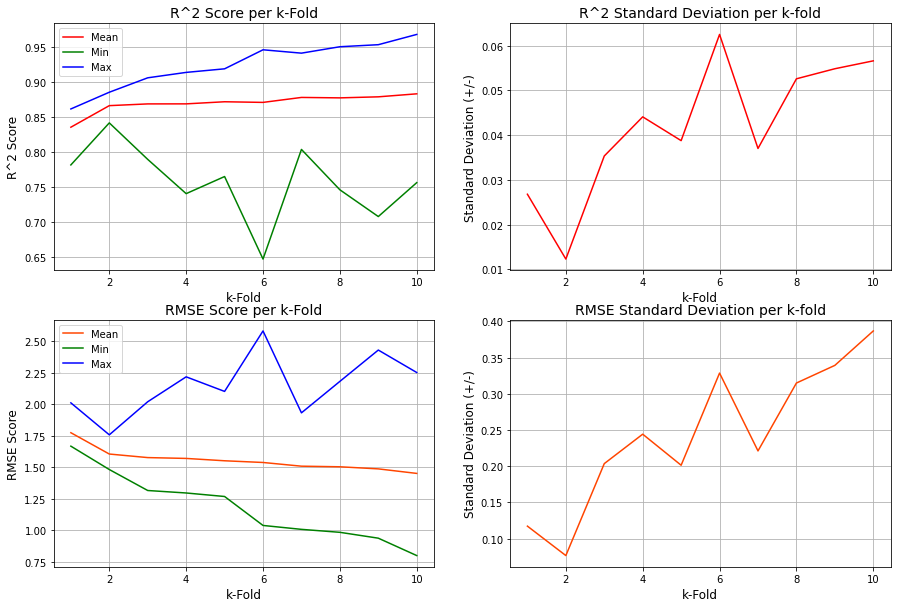

In [15]:
# Apply k-Fold Cross Validation on the training set
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Lists of values
r2_means, r2_stds, r2_mins, r2_maxs = [], [], [], []  # R^2 Scoring
rmse_means, rmse_stds, rmse_mins, rmse_maxs = [], [], [], []  # RMSE Scoring
# Cross validate for 10 k-folds, each with 3 repeats
for k in range(2, 12):
  cv = RepeatedStratifiedKFold(n_splits = k, n_repeats = 3, random_state = 0)
  r2_scores = cross_val_score(reg, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
  # scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  # scores = cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
  rmse_scores = cross_val_score(reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
  
  # Force scores to be positive
  r2_scores = abs(r2_scores)
  rmse_scores = abs(rmse_scores)

  # Print values
  print('')
  print('-- Fold: %d --' % (k-1))
  print('')
  print('R^2 Scoring:')
  print("Mean: %f" % (np.mean(r2_scores)))
  print("Std: +/- %f" % (np.std(r2_scores)))
  print("Min: %f" % (np.min(r2_scores)))
  print("Max: %f" % (np.max(r2_scores)))
  
  print('')
  print('RMSE Scoring:')
  print("Mean: %f" % (np.mean(rmse_scores)))
  print("Std: +/- %f" % (np.std(rmse_scores)))
  print("Min: %f" % (np.min(rmse_scores)))
  print("Max: %f" % (np.max(rmse_scores)))
  print('')
  
  # Append R^2 scores
  r2_means.append(np.mean(r2_scores))
  r2_stds.append(np.std(r2_scores))
  r2_mins.append(np.min(r2_scores))
  r2_maxs.append(np.max(r2_scores))
  
  # Append RMSE scores
  rmse_means.append(np.mean(rmse_scores))
  rmse_stds.append(np.std(rmse_scores))
  rmse_mins.append(np.min(rmse_scores))
  rmse_maxs.append(np.max(rmse_scores))

# Plot R^2 scores per k-fold:
fig2 = plt.figure(figsize=(15, 10))
ax1 = fig2.add_subplot(2, 2, 1)
ax1.plot(np.arange(1,11), r2_means, color='red', label='Mean')
ax1.plot(np.arange(1,11), r2_mins, color='green', label='Min')
ax1.plot(np.arange(1,11), r2_maxs, color='blue', label='Max')
ax1.set_xlabel('k-Fold', fontsize=12)
ax1.set_ylabel('R^2 Score', fontsize=12)
ax1.set_title('R^2 Score per k-Fold', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot R^2 Standard Deviations per k-fold:
ax2 = fig2.add_subplot(2, 2, 2)
ax2.plot(np.arange(1,11), r2_stds, color='red')
ax2.set_xlabel('k-Fold', fontsize=12)
ax2.set_ylabel('Standard Deviation (+/-)', fontsize=12)
ax2.set_title('R^2 Standard Deviation per k-fold', fontsize=14)
ax2.grid(True)

# Plot RMSE scores per k-fold:
ax3 = fig2.add_subplot(2, 2, 3)
ax3.plot(np.arange(1,11), rmse_means, color='orangered', label='Mean')
ax3.plot(np.arange(1,11), rmse_mins, color='green', label='Min')
ax3.plot(np.arange(1,11), rmse_maxs, color='blue', label='Max')
ax3.set_xlabel('k-Fold', fontsize=12)
ax3.set_ylabel('RMSE Score', fontsize=12)
ax3.set_title('RMSE Score per k-Fold', fontsize=14)
ax3.legend()
ax3.grid(True)

# Plot RMSE Standard Deviations per k-fold:
ax4 = fig2.add_subplot(2, 2, 4)
ax4.plot(np.arange(1,11), rmse_stds, color='orangered')
ax4.set_xlabel('k-Fold', fontsize=12)
ax4.set_ylabel('Standard Deviation (+/-)', fontsize=12)
ax4.set_title('RMSE Standard Deviation per k-fold', fontsize=14)
ax4.grid(True)

# Show subplot
plt.show()


<table border = "1">
  <thead>
    <th colspan = "3">Cross-Validation Results</th>
  </thead>
  <tbody>
    <tr>
      <td><b></b></td>
      <td><b>R^2</b></td>
      <td><b>RMSE</b></td>
    </tr>
    <tr>
      <td><b>Mean</b></td>
      <td>0.883</td>
      <td>1.451</td>
    </tr>
    <tr>
      <td><b>Std.</b></td>
      <td>0.057</td>
      <td>0.387</td>
    </tr>
    <tr>
      <td><b>Min</b></td>
      <td>0.756</td>
      <td>0.800</td>
    </tr>
    <tr>
      <td><b>Max</b></td>
      <td>0.968</td>
      <td>2.252</td>
    </tr>
  </tbody>
</table>

In [16]:
# Apply Grid Search for parameter tuning
from sklearn.model_selection import GridSearchCV

# param_dict = {'boosting_type': ['gbdt'],
#               'max_depth': [10, 25, 50, 75, 100],
#               'n_estimators': [50, 100, 150, 200, 250],
#               'learning_rate': [0.01, 0.05, 0.1, 0.15],
#               'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
#               'num_leaves': [1, 5, 10, 20],
#               'min_split_gain': [2, 5, 10],
#               'max_samples': [0.2, 0.4, 0.6, 0.8, 1],
#               'reg_alpha': [0.5, 1, 1.5, 2, 5, 10],
#               'reg_lambda': [0.5, 1, 1.5, 2, 5, 10],
#               'subsample': [1, 1.5, 2, 5, 10],
#               'subsample_freq': [5, 10, 15, 20, 25],
#               'random_state': [0, 1, 2, 5, 10, 20, 40]}

param_dict = {'max_depth': [2],
              'n_estimators': [115],
              'learning_rate': [0.16],
              'colsample_bytree': [1],
              'num_leaves': [4],
              'reg_alpha': [2.2],
              'subsample': [1],
              'subsample_freq': [1],
              'random_state': [0, 1]}

# grid = GridSearchCV(reg, param_dict, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# grid = GridSearchCV(reg, param_dict, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# grid = GridSearchCV(reg, param_dict, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
grid = GridSearchCV(reg, param_dict, scoring='r2', cv=cv, n_jobs=-1)
results = grid.fit(X_train, y_train)

# Summarize results
best_score = grid.best_score_
best_parameters = grid.best_params_
print("Best Score: %.3f%%" % (np.abs(best_score * 100)))  # R^2 Scoring
# print("Best Score: %.3f%%" % (np.abs(best_score)))  # RMSE
print("Best Parameters: ", best_parameters)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  % (min_groups, self.n_splits)), UserWarning)


Best Score: 88.286%
Best Parameters:  {'colsample_bytree': 1, 'learning_rate': 0.16, 'max_depth': 2, 'n_estimators': 115, 'num_leaves': 4, 'random_state': 0, 'reg_alpha': 2.2, 'subsample': 1, 'subsample_freq': 1}


<table border = "1">
  <thead>
    <th colspan = "2">Grid Search Results</th>
  </thead>
  <tbody>
    <tr>
      <td><b>Best Score</b></td>
      <td>88.286%</td>
    </tr>
    <tr>
      <td colspan="2"><b>Best Parameters:</b></td>
    </tr>
    <tr>
      <td><b>max_depth</b></td>
      <td>2</td>
    </tr>
    <tr>
      <td><b>n_estimators</b></td>
      <td>115</td>
    </tr>
    <tr>
      <td><b>learning_rate</b></td>
      <td>0.16</td>
    </tr>
    <tr>
      <td><b>colsample_bytree</b></td>
      <td>1</td>
    </tr>
    <tr>
      <td><b>num_leaves</b></td>
      <td>4</td>
    </tr>
    <tr>
      <td><b>reg_alpha</b></td>
      <td>2.2</td>
    </tr>
    <tr>
      <td><b>subsample</b></td>
      <td>1</td>
    </tr>
    <tr>
      <td><b>subsample_freq</b></td>
      <td>1</td>
    </tr>
    <tr>
      <td><b>random_state</b></td>
      <td>0</td>
    </tr>
  </tbody>
</table>